In [2]:
from langchain.chat_models import ChatOpenAI
import os
from dotenv import load_dotenv
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import pandas as pd
import json

In [3]:
load_dotenv()

openai_key=os.getenv("OPENAI_API_KEY")
llm=ChatOpenAI(model="gpt-4o-mini",temperature=0)

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(
    model="text-embedding-ada-002",
    api_key=openai_key
)

C:\Users\muaaz\AppData\Local\Temp\ipykernel_4644\2819571407.py:4: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm=ChatOpenAI(model="gpt-4o-mini",temperature=0)


In [4]:
output_parser=StrOutputParser()

prompt = ChatPromptTemplate.from_messages([
    ("system", "Answer the following question using the provided context in the same language as the context: {context}"),
    ("user", "{question}")
])

In [5]:
# Initialize embeddings and LLM for evaluation
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini"))
evaluator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings(model="text-embedding-3-small",
    api_key=openai_key))

In [11]:
def string_to_dictionary(input_string):
    result_dict = {}
    lines = input_string.splitlines()
    
    for line in lines:
        if ":" in line:
            key, value = line.split(":", 1)
            key = key.strip()
            value = value.strip()
            result_dict[key] = value

    return result_dict

eval_dataset=pd.read_csv('updated_murshad.csv')

contexts=eval_dataset['input_context'].to_list()
responses=eval_dataset['output_output'].to_list()
queries=eval_dataset['input_query1'].to_list()

# Convert the string to a dictionary
for index,response in enumerate(responses):
    responses[index]=json.loads(response)['content']

for index,context in enumerate(contexts):
    contexts[index]=string_to_dictionary(context)
    contexts[index]=' '.join(f"{key}: {value}" for key, value in contexts[index].items() if key != 'metadata' and value)
    contexts[index]=contexts[index].replace("content:","")


In [12]:
contexts[0]

' المجلة األكاديمية لألبحاث والنشر العلمي | اإلصدار : في ضوء نتائج الدراسة ومناقشتها يوصي الباحث بمجموعة من التوصيات المهمة أهمها ISSN: 2706-6495 Email: fsalallah@kau.edu.sa'

Evaluation Metrics

In [ ]:
#Context Precision: a metric that uses the LLM to compare each of the retrieved context or chunk present in retrieved_contexts with response.

from ragas import SingleTurnSample
from ragas.metrics import LLMContextPrecisionWithoutReference

context_precision = LLMContextPrecisionWithoutReference(llm=evaluator_llm)

context_precision_score=[]

for context,response,query in zip(contexts,responses,queries):
    sample = SingleTurnSample(
        user_input=query,
        response=response,
        retrieved_contexts=[context],
    )
    context_precision_score.append(await context_precision.single_turn_ascore(sample))
    print(context_precision_score)


#Faithfulness metric measures the factual consistency of the generated answer against the given context
from ragas import SingleTurnSample 
from ragas.metrics import Faithfulness

scorer = Faithfulness(llm=evaluator_llm)
faithfulness_score=[]

for context,response,query in zip(contexts,responses,queries):
    sample = SingleTurnSample(
        user_input=query,
        response=response,
        retrieved_contexts=[context], 
    )
    faithfulness_score.append(await scorer.single_turn_ascore(sample))
    print(faithfulness_score)

#FactualCorrectness is a metric that compares and evaluates the factual accuracy of the generated response with the reference

from ragas.dataset_schema import SingleTurnSample
from ragas.metrics._factual_correctness import FactualCorrectness

factualcorrectness_score=[]

references=[]

chain = prompt | llm | output_parser

for context,response,query in zip(contexts,responses,queries):
    sample = SingleTurnSample(
        response=response,
        reference=chain.invoke({"context":context,"question":query})
    )

    scorer = FactualCorrectness(mode="precision")
    scorer.llm = evaluator_llm
    factualcorrectness_score.append(float(await scorer.single_turn_ascore(sample)))
    print(factualcorrectness_score)

#The concept of Answer Semantic Similarity pertains to the assessment of the semantic resemblance between the generated answer and the ground truth.

from ragas.dataset_schema import SingleTurnSample
from ragas.metrics import SemanticSimilarity

semantic_similarity=[]
count=0
for context,response,query in zip(contexts,responses,queries):
    sample = SingleTurnSample(
        response=response,
        reference=chain.invoke({"context":context,"question":query})
    )
    count+=1
    scorer = SemanticSimilarity()
    scorer.embeddings = evaluator_embeddings
    semantic_similarity.append(await scorer.single_turn_ascore(sample))
    print(semantic_similarity)

In [ ]:
# Round large decimals number till 5 decimal places

for index,a in enumerate(context_precision_score):
    context_precision_score[index]="{:.5f}".format(a)

for index,a in enumerate(semantic_similarity):
    semantic_similarity[index]="{:.5f}".format(a)

for index,a in enumerate(factualcorrectness_score):
    factualcorrectness_score[index]="{:.5f}".format(a)

for index,a in enumerate(faithfulness_score):
    faithfulness_score[index]="{:.5f}".format(a)

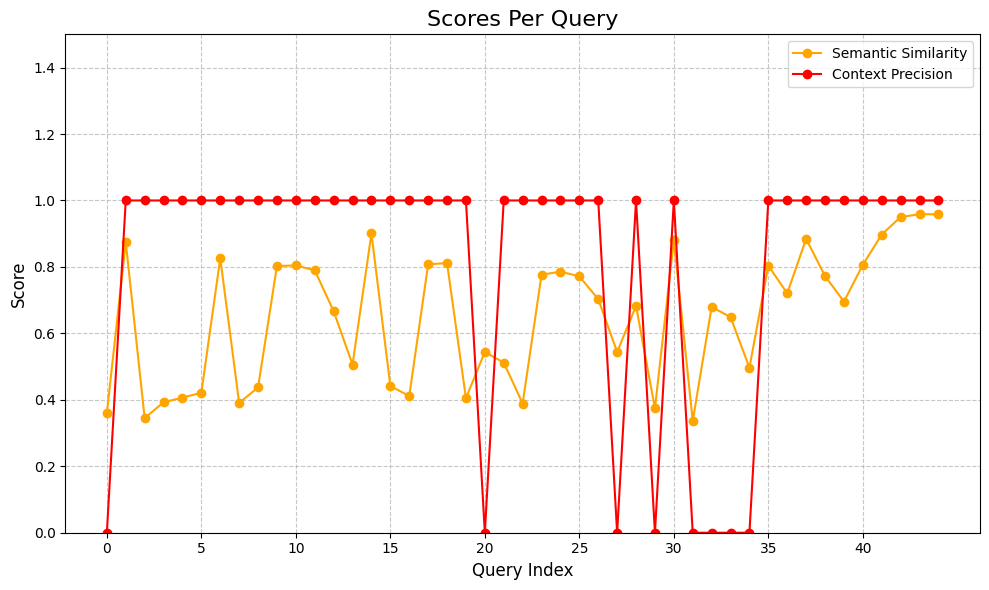

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create the plot
plt.figure(figsize=(10, 6))

plt.plot(range(len(semantic_similarity)), semantic_similarity, 'o-', color="orange", label="Semantic Similarity")
plt.plot(range(len(context_precision_score)), context_precision_score, 'o-', color="red", label="Context Precision")

# Customize the plot
plt.title("Scores Per Query", fontsize=16)
plt.xlabel("Query Index", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1.5)  # Scores range between 0 and 1
plt.xticks(range(0, len(semantic_similarity), 5))
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

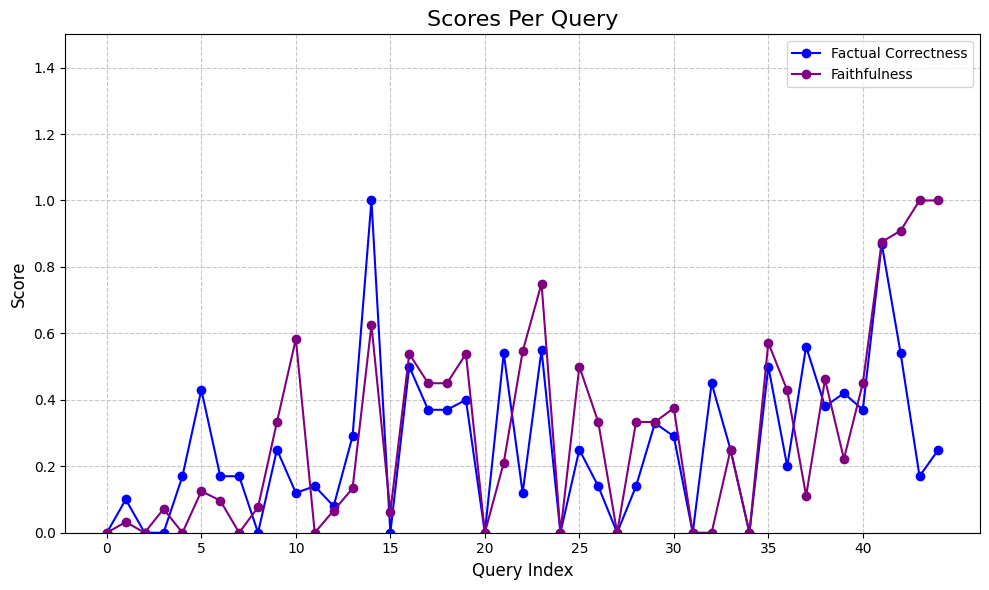

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Create the plot
plt.figure(figsize=(10, 6))

# Plot individual lists
plt.plot(range(len(factualcorrectness_score)), factualcorrectness_score, 'o-', color="blue", label="Factual Correctness")
plt.plot(range(len(faithfulness_score)), faithfulness_score, 'o-', color="purple", label="Faithfulness")

# Customize the plot
plt.title("Scores Per Query", fontsize=16)
plt.xlabel("Query Index", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1.5)  # Scores range between 0 and 1
plt.xticks(range(0, len(semantic_similarity), 5))
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

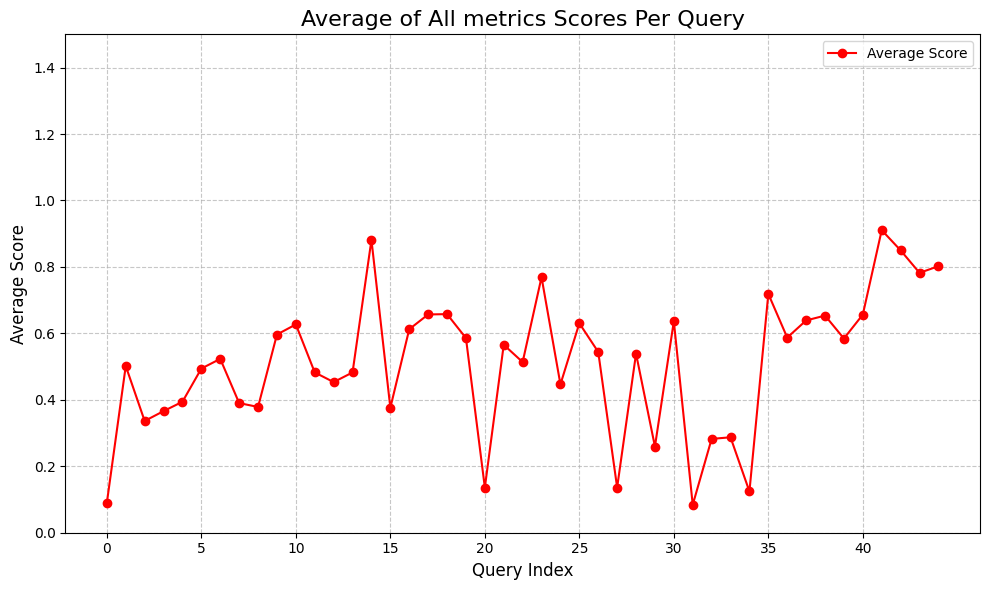

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate averages for each index
average_scores = [
    np.mean([factualcorrectness_score[i],semantic_similarity[i], context_precision_score[i],faithfulness_score[i]])
    for i in range(len(faithfulness_score))
]

plt.figure(figsize=(10, 6))
plt.plot(range(0, len(average_scores)), average_scores, 'o-', color="red", label="Average Score")

plt.title("Average of All metrics Scores Per Query", fontsize=16)
plt.xlabel("Query Index", fontsize=12)
plt.ylabel("Average Score", fontsize=12)
plt.ylim(0, 1.5)  # Scores range between 0 and 1
plt.xticks(range(0, len(average_scores), 5)) 
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()


In [6]:
# get evaluation data from csv

import pandas as pd
data=pd.read_csv("updated_data_murshad_evaluation_score.csv")
faithfulness_score=data["faithfulness_score"].to_list()
factualcorrectness_score=data["factualcorrectness_score"].to_list()
semantic_similarity=data["semantic_similarity"].to_list()
context_precision_score=data["Context_precision_score"].to_list()